[View in Colaboratory](https://colab.research.google.com/github/jagatfx/turicreate-colab/blob/master/turicreate_object_detection.ipynb)

# Object Detection
https://apple.github.io/turicreate/docs/userguide/object_detection/

Object detection is the task of simultaneously classifying (what) and localizing (where) object instances in an image.

## Turi Create and GPU Setup

In [0]:
!apt install libnvrtc8.0
!pip uninstall -y mxnet-cu80 && pip install mxnet-cu80==1.1.0
!pip install turicreate

## Google Drive Access

You will be asked to click a link to generate a secret key to access your Google Drive. 

Copy and paste secret key it into the space provided with the notebook.

In [0]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

## Fetch Data

The dataset that we will use is INRIA Annotations for Graz-02 (IG02). 

https://lear.inrialpes.fr/people/marszalek/data/ig02/

The IG02 dataset is described further in:

1. Marcin Marszałek and Cordelia Schmid. Accurate Object Localization with Shape Masks. IEEE Conference on Computer Vision & Pattern Recognition, 2007.
2. A. Opelt, A. Pinz, M. Fussenegger, P. Auer. Generic Object Recognition with Boosting. IEEE Transactions on Pattern Recognition and Machine Intelligence (PAMI), Vol.28, No. 3, March 2006.

Our goal is to make a detector that can spot bikes and cars.

See https://apple.github.io/turicreate/docs/userguide/object_detection/#data-acquisition for notes on data creation.

In [0]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  

def load_datafile_from_drive(filename, remote_url=None):
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_datafile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)
  

In [2]:
load_cache_extract_datafile("ig02-v1.0-bikes.zip", "bikes", "https://lear.inrialpes.fr/people/marszalek/data/ig02/ig02-v1.0-bikes.zip")

have ig02-v1.0-bikes.zip in Google Drive, copying to workspace...
extracting ig02-v1.0-bikes.zip...
    extracting file bikes/
    extracting file bikes/bike_001.mask.0.png
    extracting file bikes/bike_001.mask.1.png
    extracting file bikes/bike_001.mask.2.png
    extracting file bikes/bike_001.mask.3.png
    extracting file bikes/bike_002.mask.0.png
    extracting file bikes/bike_003.mask.0.png
    extracting file bikes/bike_004.mask.0.png
    extracting file bikes/bike_005.mask.0.png
    extracting file bikes/bike_006.mask.0.png
    extracting file bikes/bike_006.mask.1.png
    extracting file bikes/bike_007.mask.0.png
    extracting file bikes/bike_008.mask.0.png
    extracting file bikes/bike_009.mask.0.png
    extracting file bikes/bike_010.mask.0.png
    extracting file bikes/bike_011.mask.0.png
    extracting file bikes/bike_012.mask.0.png
    extracting file bikes/bike_013.mask.0.png
    extracting file bikes/bike_014.mask.0.png
    extracting file bikes/bike_015.mask.0.png

In [3]:
load_cache_extract_datafile("ig02-v1.0-cars.zip", "cars", "https://lear.inrialpes.fr/people/marszalek/data/ig02/ig02-v1.0-cars.zip")

have ig02-v1.0-cars.zip in Google Drive, copying to workspace...
extracting ig02-v1.0-cars.zip...
    extracting file cars/
    extracting file cars/carsgraz_001.mask.0.png
    extracting file cars/carsgraz_002.mask.0.png
    extracting file cars/carsgraz_003.mask.0.png
    extracting file cars/carsgraz_004.mask.0.png
    extracting file cars/carsgraz_005.mask.0.png
    extracting file cars/carsgraz_006.mask.0.png
    extracting file cars/carsgraz_007.mask.0.png
    extracting file cars/carsgraz_008.mask.0.png
    extracting file cars/carsgraz_009.mask.0.png
    extracting file cars/carsgraz_010.mask.0.png
    extracting file cars/carsgraz_011.mask.0.png
    extracting file cars/carsgraz_012.mask.0.png
    extracting file cars/carsgraz_013.mask.0.png
    extracting file cars/carsgraz_014.mask.0.png
    extracting file cars/carsgraz_015.mask.0.png
    extracting file cars/carsgraz_015.mask.1.png
    extracting file cars/carsgraz_016.mask.0.png
    extracting file cars/carsgraz_017.mask.

## Setup Turi Create

In [0]:
import mxnet as mx
import turicreate as tc

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

## Prepare Data

In [0]:
import os

In [0]:
ig02_path = './ig02'

# Load all images in random order
raw_sf = tc.image_analysis.load_images(ig02_path, recursive=True,
                                       random_order=True)

In [0]:
def mask_to_bbox_coordinates(img):
    """
    Takes a tc.Image of a mask and returns a dictionary representing bounding
    box coordinates: e.g. {'x': 100, 'y': 120, 'width': 80, 'height': 120}
    """
    import numpy as np
    mask = img.pixel_data
    if mask.max() == 0:
        return None
    # Take max along both x and y axis, and find first and last non-zero value
    x0, x1 = np.where(mask.max(0))[0][[0, -1]]
    y0, y1 = np.where(mask.max(1))[0][[0, -1]]

    return {'x': (x0 + x1) / 2, 'width': (x1 - x0),
            'y': (y0 + y1) / 2, 'height': (y1 - y0)}

In [0]:
# Split file names so that we can determine what kind of image each row is
# E.g. bike_005.mask.0.png -> ['bike_005', 'mask']
info = raw_sf['path'].apply(lambda path: os.path.basename(path).split('.')[:2])

# Rename columns to 'name' and 'type'
info = info.unpack().rename({'X.0': 'name', 'X.1': 'type'})

# Add to our main SFrame
raw_sf = raw_sf.add_columns(info)

# Extract label (e.g. 'bike') from name (e.g. 'bike_003')
raw_sf['label'] = raw_sf['name'].apply(lambda name: name.split('_')[0])

# Split into images and masks
sf_images = raw_sf[raw_sf['type'] == 'image']
sf_masks = raw_sf[raw_sf['type'] == 'mask']

# Convert masks to bounding boxes (drop masks that did not contain bounding box)
sf_masks['coordinates'] = sf_masks['image'].apply(mask_to_bbox_coordinates)

# There can be empty masks (which returns None), so let's get rid of those
sf_masks = sf_masks.dropna('coordinates')

# Combine label and coordinates into a bounding box dictionary
sf_masks = sf_masks.pack_columns(['label', 'coordinates'],
                                 new_column_name='bbox', dtype=dict)

# Combine bounding boxes of the same 'name' into lists
sf_annotations = sf_masks.groupby('name',
                                 {'annotations': tc.aggregate.CONCAT('bbox')})

# Join annotations with the images. Note, some images do not have annotations,
# but we still want to keep them in the dataset. This is why it is important to
# a LEFT join.
sf = sf_images.join(sf_annotations, on='name', how='left')

# The LEFT join fills missing matches with None, so we replace these with empty
# lists instead using fillna.
sf['annotations'] = sf['annotations'].fillna([])

# Remove unnecessary columns
del sf['type']

In [0]:
# Save SFrame
sf.save('ig02.sframe')

In [11]:
sf

Columns:
	path	str
	image	Image
	name	str
	label	str
	annotations	list

Rows: 785

Data:
+-------------------------------+------------------------+--------------+
|              path             |         image          |     name     |
+-------------------------------+------------------------+--------------+
| ./ig02/cars/carsgraz_141.i... | Height: 480 Width: 640 | carsgraz_141 |
| ./ig02/cars/carsgraz_193.i... | Height: 480 Width: 640 | carsgraz_193 |
| ./ig02/cars/carsgraz_185.i... | Height: 480 Width: 640 | carsgraz_185 |
| ./ig02/bikes/bike_236.imag... | Height: 640 Width: 480 |   bike_236   |
| ./ig02/bikes/bike_167.imag... | Height: 480 Width: 640 |   bike_167   |
| ./ig02/bikes/bike_297.imag... | Height: 480 Width: 640 |   bike_297   |
| ./ig02/cars/carsgraz_314.i... | Height: 480 Width: 640 | carsgraz_314 |
| ./ig02/bikes/bike_064.imag... | Height: 480 Width: 640 |   bike_064   |
| ./ig02/cars/carsgraz_410.i... | Height: 480 Width: 640 | carsgraz_410 |
| ./ig02/cars/carsgraz_327.i... | Height: 480 Width: 640 | carsgraz_327 |
+-------------------------------+------------------------+--------------+
+----------+-------------------------------+
|  label   |          annotations          |
+----------+-------------------------------+
| carsgraz | [{'label': 'carsgraz', 'co... |
| carsgraz | [{'label': 'carsgraz', 'co... |
| carsgraz | [{'label': 'carsgraz', 'co... |
|   bike   | [{'label': 'bike', 'coordi... |
|   bike   | [{'label': 'bike', 'coordi... |
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
| carsgraz | [{'label': 'carsgraz', 'co... |
+----------+-------------------------------+
[785 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
from IPython.display import display
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import glob
import random
import base64
import pandas as pd

def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((150, 150), Image.LANCZOS)
  return i
  
def get_thumbnail_from_image(img):
  i = img.copy()
  i.thumbnail((150, 150), Image.LANCZOS)
  return i

def image_base64(im):
  if isinstance(im, str):
    im = get_thumbnail(im)
  with BytesIO() as buffer:
    im.save(buffer, 'jpeg')
    return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
  return f'<img style="display:inline;margin:1px" src="data:image/jpeg;base64,{image_base64(im)}">'
  
def preview_images(reference_data, num_previews=30):
  images = list(map(lambda x:image_formatter(get_thumbnail(x)), reference_data[0:num_previews]['path']))
  display(HTML(''.join(images)))


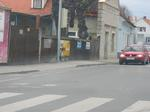
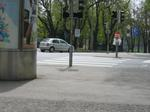
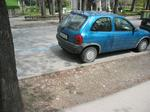
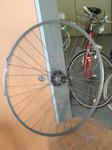
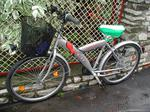
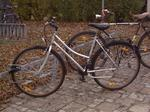
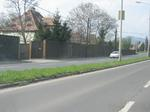
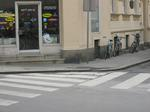
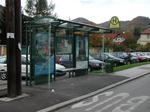
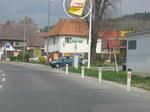
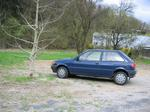
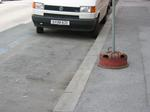
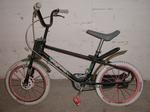
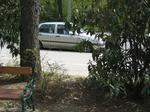
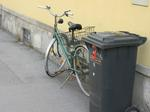
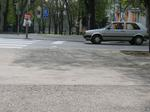
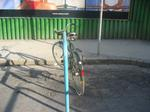
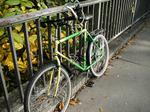
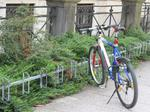
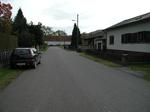
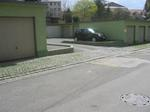
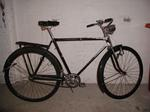
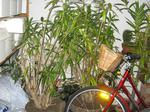
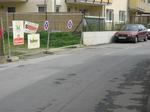
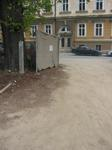
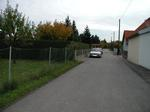
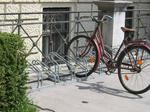
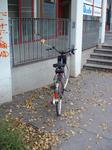
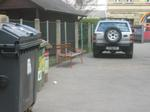
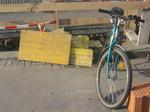

In [12]:
data = sf
preview_images(data)

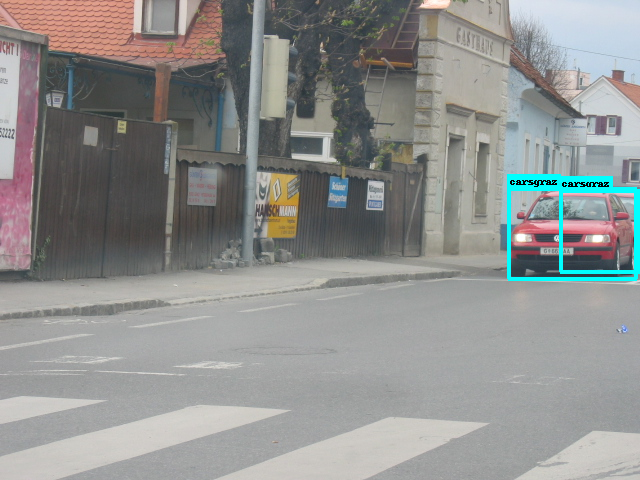

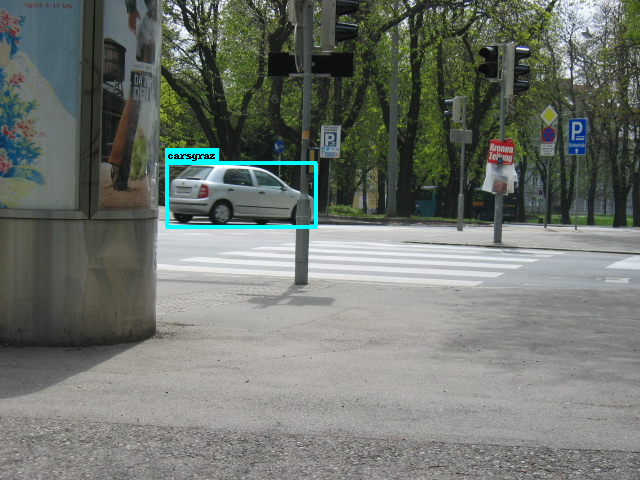

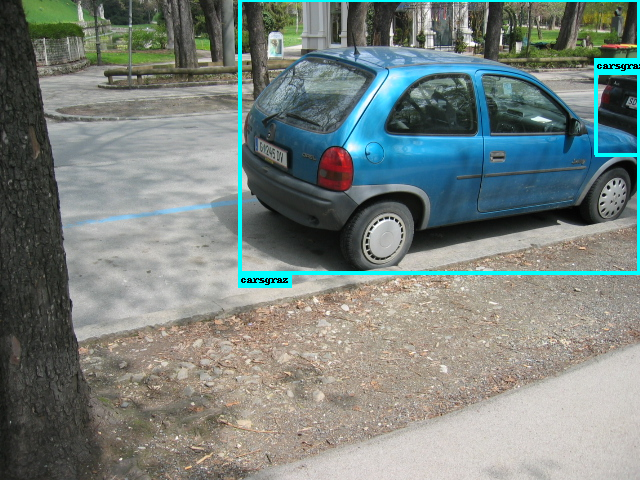

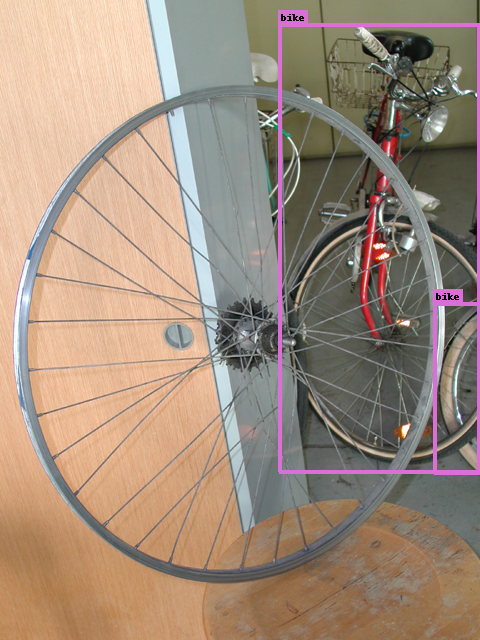

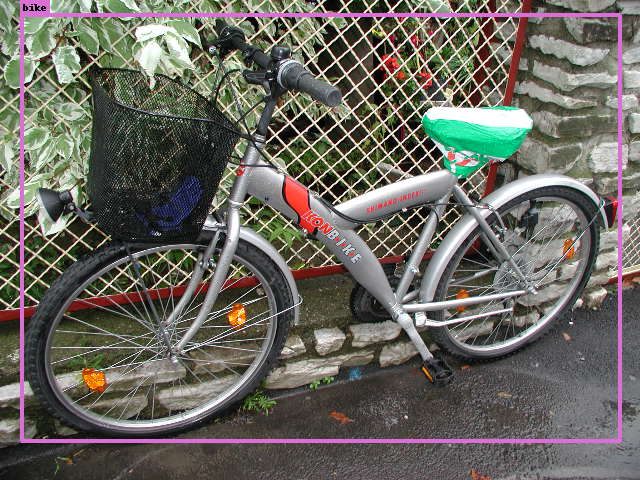

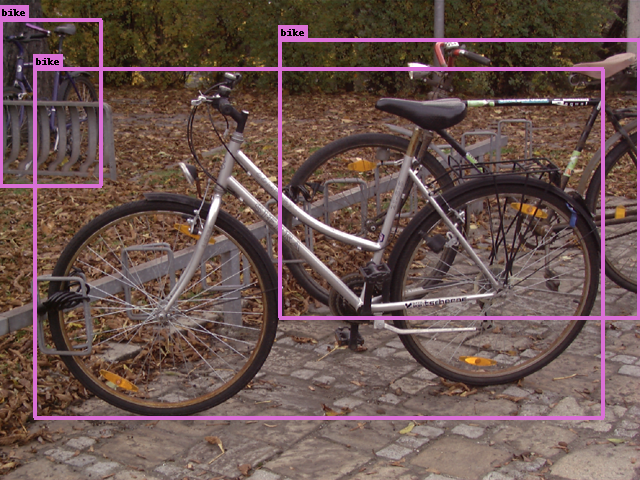

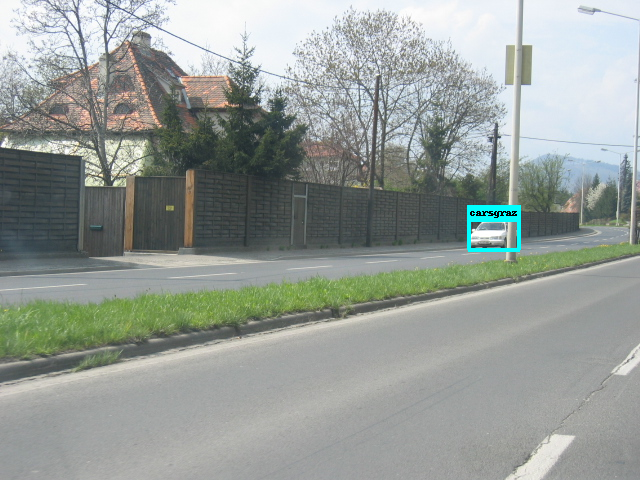

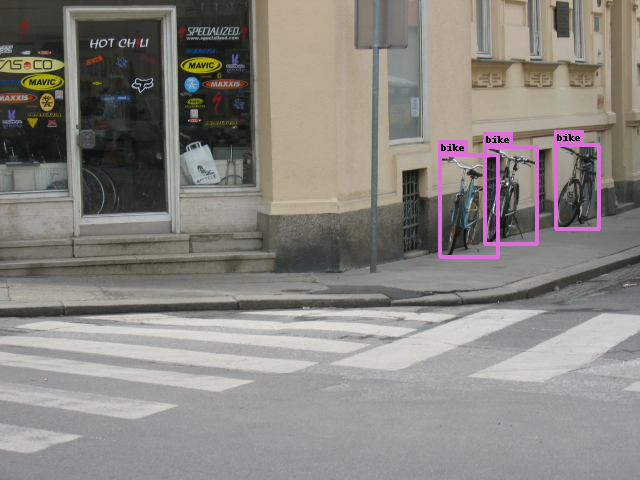

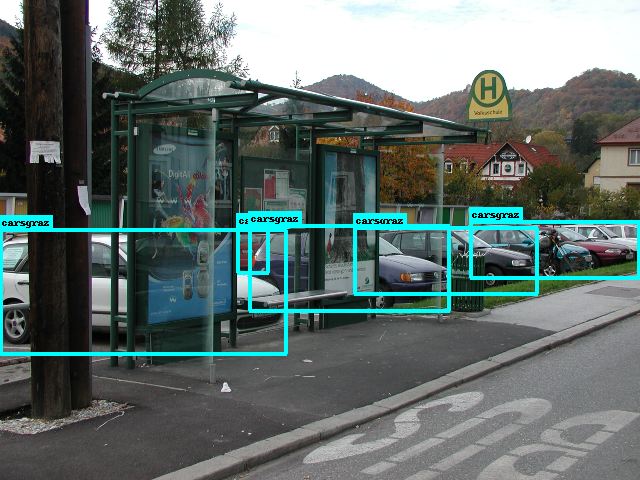

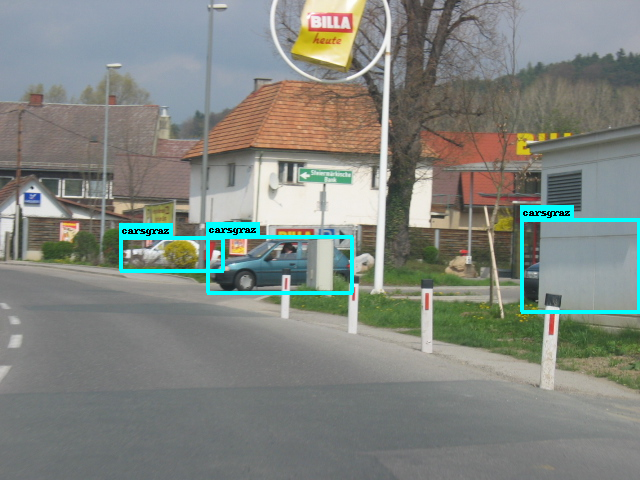

In [25]:
# draw bounding box to explore how it wraps objects
data['image_with_ground_truth'] = tc.object_detector.util.draw_bounding_boxes(data['image'], data['annotations'])
for i in range(10):
  tc_img = data['image_with_ground_truth'][i]
  img = Image.fromarray(tc_img.pixel_data)
  display(img)

## Train model on data

In [0]:
# Make a train-test split
train_data, test_data = data.random_split(0.8)

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

## Create Model
https://apple.github.io/turicreate/docs/api/generated/turicreate.object_detector.create.html

In [14]:
# Create a model
model = tc.object_detector.create(train_data)

Using 'image' as feature column
Using 'annotations' as annotations column
Download completed: /var/tmp/model_cache/darknet.params
Setting 'batch_size' to 32
Using GPU to create model (Tesla K80)
Setting 'max_iterations' to 5000
+--------------+--------------+--------------+
| Iteration    | Loss         | Elapsed Time |
+--------------+--------------+--------------+
| 1            | 6.964        | 16.0         |
| 7            | 6.679        | 27.3         |
| 13           | 6.287        | 38.7         |
| 19           | 5.921        | 49.4         |
| 24           | 5.638        | 60.7         |
| 30           | 5.268        | 72.0         |
| 36           | 5.003        | 83.0         |
| 41           | 4.870        | 93.9         |
| 47           | 4.626        | 105.0        |
| 53           | 4.350        | 116.1        |
| 59           | 4.100        | 126.9        |
| 64           | 4.131        | 137.8        |
| 70           | 3.959        | 148.8        |
| 76           | 3.7

KeyboardInterrupt: ignored

## Making Predictions

In [26]:
test_data

Columns:
	path	str
	image	Image
	name	str
	label	str
	annotations	list

Rows: 144

Data:
+-------------------------------+------------------------+--------------+
|              path             |         image          |     name     |
+-------------------------------+------------------------+--------------+
| ./ig02/bikes/bike_317.imag... | Height: 480 Width: 640 |   bike_317   |
| ./ig02/cars/carsgraz_013.i... | Height: 480 Width: 640 | carsgraz_013 |
| ./ig02/cars/carsgraz_407.i... | Height: 480 Width: 640 | carsgraz_407 |
| ./ig02/bikes/bike_117.imag... | Height: 480 Width: 640 |   bike_117   |
| ./ig02/cars/carsgraz_198.i... | Height: 480 Width: 640 | carsgraz_198 |
| ./ig02/bikes/bike_306.imag... | Height: 480 Width: 640 |   bike_306   |
| ./ig02/bikes/bike_305.imag... | Height: 480 Width: 640 |   bike_305   |
| ./ig02/cars/carsgraz_089.i... | Height: 480 Width: 640 | carsgraz_089 |
| ./ig02/bikes/bike_340.imag... | Height: 480 Width: 640 |   bike_340   |
| ./ig02/cars/carsgraz_217.i... | Height: 480 Width: 640 | carsgraz_217 |
+-------------------------------+------------------------+--------------+
+----------+-------------------------------+
|  label   |          annotations          |
+----------+-------------------------------+
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
| carsgraz | [{'label': 'carsgraz', 'co... |
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
|   bike   | [{'label': 'bike', 'coordi... |
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
|   bike   | [{'label': 'bike', 'coordi... |
| carsgraz | [{'label': 'carsgraz', 'co... |
+----------+-------------------------------+
[144 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [0]:
# Save predictions to an SArray
predictions = model.predict(test_data)

# Evaluate the model and save the results into a dictionary
metrics = model.evaluate(test_data)
print(metrics)

In [0]:
test_images = test_data['image'][0:10]
test = tc.SFrame({'image': test_images})
test['predictions'] = model.predict(test)

In [0]:
test['image_with_predictions'] = tc.object_detector.util.draw_bounding_boxes(test['image'], test['predictions'])
for i in range(10):
  tc_img = test['image_with_predictions'][i]
  img = Image.fromarray(tc_img.pixel_data)
  display(img)

## Save and Export Model

In [0]:
# Save the model for later use in Turi Create
model.save('ObjectDetection.model')

# Export for use in Core ML
model.export_coreml('ObjectDetection.mlmodel')

In [0]:
# download mlmodel locally
from google.colab import files
files.download("ObjectDetection.mlmodel")

In [0]:
# copy model to Google Drive
from shutil import copy
copy("/content/ObjectDetection.mlmodel", "/content/drive/My Drive/Colab Notebooks/data/models/ObjectDetection.mlmodel")

In [0]:
# copy model to Google Drive
from shutil import copytree
copytree("/content/ObjectDetection.model", "/content/drive/My Drive/Colab Notebooks/data/models/ObjectDetection.model")

See https://apple.github.io/turicreate/docs/userguide/object_detection/export-coreml.html for CoreML deployment notes